This works really well! Tomorrow, first thing, is to upload to GitHub! 

Then, I will try to change my model to overriide the train_step and test_step functions as explained here: 

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

Then I can just run model.compile and model.fit! I can also easily add things like early stopping

In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt

Global Constants

In [2]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.)*DAY/YEAR # 1 hour
MSUN = 1.98892e+30
MEARTH = 5.9742e+24

Helper functions

In [3]:
#def shuffle_data(X):
#    indices = np.random.permutation(np.arange(len(X)))
#    Y = np.empty(X.shape)
#    for i in range(len(X)):
#        Y[i] = X[indices[i]]       
#    return Y

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

Training variables

In [4]:
# Training variables
batch_size_tr = 75
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
total_time_traj = 20 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 75000 
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [5]:
masses = np.array([MSUN/MEARTH, # Sun
                   0.33011 * 10**24/MEARTH, # Mercury
                   4.8685 * 10**24/MEARTH, # Venus
                   1, # Earth
                   0.642 * 10**24/MEARTH, #Mars
                   1898.19 * 10**24/MEARTH, # Jupiter
                   568 * 10**24/MEARTH, # Saturn
          ])

orbit_sun = np.loadtxt('nasa_orbits/sun_center/sun.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mercury = np.loadtxt('nasa_orbits/sun_center/mercury.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_venus = np.loadtxt('nasa_orbits/sun_center/venus.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_earth = np.loadtxt('nasa_orbits/sun_center/earth.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mars = np.loadtxt('nasa_orbits/sun_center/mars.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_jupiter = np.loadtxt('nasa_orbits/sun_center/jupiter.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_io = np.loadtxt('nasa_orbits/sun_center/io.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_europa = np.loadtxt('nasa_orbits/sun_center/europa.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_ganymede = np.loadtxt('nasa_orbits/sun_center/ganymede.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_callisto = np.loadtxt('nasa_orbits/sun_center/callisto.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_saturn = np.loadtxt('nasa_orbits/sun_center/saturn.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_dione = np.loadtxt('nasa_orbits/sun_center/dione.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_rhea = np.loadtxt('nasa_orbits/sun_center/rhea.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_titan = np.loadtxt('nasa_orbits/sun_center/titan.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')

io_mass =0.08931900 * 10**24/MSUN
europa_mass =0.048 * 10**24/MSUN
ganymede_mass = 0.14819 * 10**24/MSUN
callisto_mass =0.10759 * 10**24/MSUN

dione_mass =0.0011 * 10**24/MSUN
rhea_mass =0.0023 * 10**24/MSUN
titan_mass =0.135 * 10**24/MSUN

orbit_jupiter[:,:] += (orbit_io[:,:]*io_mass + orbit_europa[:,:]*europa_mass + 
                       orbit_ganymede[:,:]*ganymede_mass + orbit_callisto[:,:]*callisto_mass)/masses[5]


orbit_saturn[:,:] += (orbit_dione[:,:]*dione_mass + orbit_rhea[:,:]*rhea_mass + 
                       orbit_titan[:,:]*titan_mass)/masses[6]

nplanets = len(masses)
nedges = nplanets*(nplanets-1)//2

In [6]:
data = np.stack([orbit_sun, 
                 orbit_mercury, 
                 orbit_venus,
                 orbit_earth, 
                 orbit_mars, 
                 orbit_jupiter, 
                 orbit_saturn
                ])
data = data.transpose(2,0,1)

# Change frame of reference to the barycenter of the planets we are using
P = masses[np.newaxis, :, np.newaxis]*data[:,:,3:]
V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
data[:,:,3:] -= V_ref

A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A 
data = data[:-1]

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

D_tr = np.empty([len(data_tr), nedges, 3])
D_val = np.empty([len(data_val), nedges, 3])
k=0
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 

D_tr_flat = np.reshape(D_tr, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val,[1, num_time_steps_val*nedges, 3])

A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")
D_tr_batches = tf.split(D_tr,  1000)
A_tr_batches = tf.split(A_tr,  1000)

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val_flat, A_val_flat))

#D_val = tf.convert_to_tensor(D_val[:,:,:], dtype="float32")
#A_val = tf.convert_to_tensor(A_val/A_norm, dtype="float32")

#D_val_flat = tf.reshape(D_val, shape = [num_time_steps_val*nedges, 3])
#A_val_flat = tf.reshape(A_val/A_norm, shape = [num_time_steps_val*nedges, 3])

nodes_tr = np.concatenate([np.log(masses)]*batch_size_tr)[:,np.newaxis]
nodes_val = np.concatenate([np.log(masses)]*num_time_steps_val)[:,np.newaxis]

senders_tr, receivers_tr = reshape_senders_receivers(senders, receivers, batch_size_tr, nplanets, nedges)
senders_val, receivers_val = reshape_senders_receivers(senders, receivers, num_time_steps_val, nplanets, nedges)

In [7]:
D_tr.shape

TensorShape([1575000, 3])

In [44]:
#nplanets, _, ntime = X.shape
loss_tracker = tf.keras.metrics.Mean(name='loss')
loss_test = tf.keras.metrics.MeanAbsoluteError(name='loss_test')

class LearnForces(tf.keras.Model):
    def __init__(self):
        super(LearnForces, self).__init__()
        self.test_loss_metric = tf.keras.metrics.MeanAbsoluteError(name='test_loss')
        self.nplanets = nplanets
        
        #m_init = tf.random_normal_initializer()
        #self.m = tf.Variable(
        #    initial_value=m_init(shape=(self.nplanets,), dtype="float32"),
        #    trainable=True,
        #)
        
        self.graph_network = gn.blocks.EdgeBlock(
            #edge_model_fn=lambda: snt.Linear(output_size=3),
            edge_model_fn=lambda: snt.nets.MLP([32, 32, 3]), 
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = False,
        )

    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.exp(graph.nodes))
        return acceleration_tr
        #output_ops_tr = tf.reshape(acceleration_tr, shape=[self.ntime, self.nplanets, 3])
        #return output_ops_tr
        
    def call(self, g, extract = False):
        #self.ntime = len(g.nodes)//nplanets
        g = self.graph_network(g)
        f = self.sum_forces(g)
        a = self.get_acceleration(f, g)
        if extract == True: 
            f = tf.reshape(g.edges, shape=[-1, nedges, 3]).numpy()
            a = tf.reshape(a, shape=[-1, nplanets, 3]).numpy()
            return a, f
        else: 
            return a
    
    def train_step(self, data):
        # Unpack the data
        D, A = data
        #print(len(D))
        
        # Could make a "get_senders_receivers" function, that takes
        # nplanets and returns the arrays. 
        # Will also have to make one that gets the nodes from the 
        # masses it is learning
        # That will make everything more self contained

        graph_dict = { 
          "nodes": nodes_tr,
          "edges": D, 
          "receivers": receivers_tr, 
          "senders": senders_tr 
           } 
    
        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(g)
            # Compute the loss
            loss = tf.keras.losses.mean_squared_error(A, predictions)
        
        # Compute gradients
        trainable_vars = model.graph_network.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self,data):
        # Unpack the data
        D, A = data
        
        graph_dict = { 
          "nodes": nodes_val,
          "edges": D, 
          "receivers": receivers_val,
          "senders": senders_val 
           } 

        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
        
        predictions = self(g)

        #self.A_pred = tf.reshape(predictions, shape=[-1, self.nplanets, 3])
        #loss_test = tf.keras.metrics.MeanAbsoluteError(A, predictions)
        #loss_tracker.update_state(loss_test)

        #self.losses.append(tf.keras.losses.MeanAbsoluteError)
        # Updates the metrics tracking the loss
        #self.compiled_loss(A, predictions, regularization_losses=self.losses) 
    
        # Update the metrics.
        loss_test.update_state(A, predictions)
        
        return {"loss": loss_test.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, loss_test]



In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=10, 
                                            restore_best_weights=True)
model = LearnForces()

model.compile()

In [60]:
model.fit(train_ds, epochs = 100, callbacks=[callback], validation_data=test_ds)

Epoch 1/100
1000/1000 [==============================] - 3s 2ms/step - loss: 5.0433 - val_loss: 1.3406
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/step - loss: 1.5857 - val_loss: 0.6113
Epoch 3/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.9845 - val_loss: 0.5205
Epoch 4/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6700 - val_loss: 0.7077
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4675 - val_loss: 0.6114
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3149 - val_loss: 0.5087
Epoch 7/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1958 - val_loss: 0.3632
Epoch 8/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1287 - val_loss: 0.2369
Epoch 9/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0873 - val_loss: 0.1727
Epoch 10/100
1000/1000 [==============================] - 1s 1ms/step - l

In [65]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 101ms/step - loss: 0.1013


0.10128261893987656

# Evaluate on validation data

In [66]:
graph_dict = { 
          "nodes": nodes_val,
          "edges": D_val_flat[0], 
          "receivers": receivers_val, 
          "senders": senders_val 
           } 
    
g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
ap ,fp = model(g, extract = True)


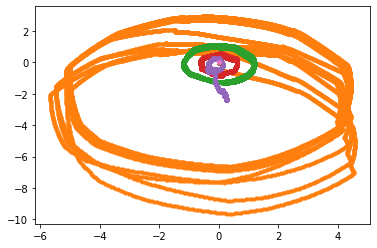

In [67]:
plt.plot(ap[:,:,0], ap[:,:,1], '.')

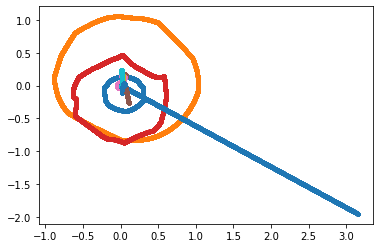

In [68]:
plt.plot(fp[:,:,0], fp[:,:,1], '.')

In [15]:
indices = [0,1,3,6,10,15]
nforce = len(fp)
X = np.zeros([(nplanets-1)*nforce,5])
F = np.zeros([(nplanets-1)*nforce,3])
F_norm = np.mean(fp)
for i in range(nplanets-1):
    #print( X[i*nforce:(i+1)*nforce].shape, positions[:,i+1,:].shape)
    X[i*nforce:(i+1)*nforce,0] = masses[i+1]
    X[i*nforce:(i+1)*nforce,1:4] = D_val[:,indices[i],:]
    X[i*nforce:(i+1)*nforce,4] = np.linalg.norm(D_val[:,indices[i],:], axis = -1)#**3
    #F[i*nforce:(i+1)*nforce,:] = forces_true[i,:,:]#/F_norm
    F[i*nforce:(i+1)*nforce,:] = fp[:,indices[i],:]/F_norm

In [16]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:5], F[:,i], niterations=5,
            binary_operators=["mult", "div"],
            unary_operators=["square", "cube", "sqrtm"])
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpfy4dfuqr/runfile.jl
Started!

Cycles per second: 2.400e+04
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           2.145e+02  0.000e+00  3.639522
5           9.064e+01  1.722e-01  mult(x0, mult(x3, -0.92044806))
6           7.948e+01  1.315e-01  square(mult(0.18403542, mult(x3, x0)))
8           7.797e+01  9.553e-03  square(mult(0.18403542, mult(mult(x3, 0.9533471), x0)))


Cycles per second: 1.210e+04
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           2.145e+02  0.000e+00  3.639522
5           9.064e+01  1.722e-01  mult(x0, mult(x3, -0.92044806))
6           7.948e+01  1.315e-01  square(mult(0.18403542, mult(x3, x0)))
8           7.797e+01  9.553e-03  square(mult(0.18403542, mult(mult(x3, 0.9533471), x0)))


Cycles per second: 9.420e+03
Hall of Fame:
-----------------------------------------
Compl


Cycles per second: 7.650e+03
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.986e+02  0.000e+00  6.920641
3           2.529e+02  1.517e-01  mult(x2, 3.153175)
9           1.213e+02  1.225e-01  cube(div(sqrtm(sqrtm(x0)), cube(div(x4, x2))))
11          1.199e+02  5.441e-03  cube(div(sqrtm(sqrtm(mult(x0, 0.92132306))), cube(div(x4, x2))))


Cycles per second: 7.320e+03
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.986e+02  0.000e+00  6.920641
3           2.529e+02  1.517e-01  mult(x2, 3.153175)
9           1.213e+02  1.225e-01  cube(div(sqrtm(sqrtm(x0)), cube(div(x4, x2))))
11          1.199e+02  5.441e-03  cube(div(sqrtm(sqrtm(mult(x0, 0.92132306))), cube(div(x4, x2))))


Cycles per second: 6.170e+03
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.986e+02  0.000e+00  6.920641
3           2.529e+

In [23]:
equations[0]

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,5,90.64335,0.000000e+00,"mult(x0, mult(x3, -0.92044806))",-0.92044806*x0*x3,<function _lambdifygenerated at 0x7f8316e8e050>
1,6,77.97138,1.505907e-01,"square(mult(mult(x3, x0), 0.17538396))",0.0307595334252816*x0**2*x3**2,<function _lambdifygenerated at 0x7f830d25e170>
2,8,77.97129,5.771352e-07,"square(mult(0.18403542, mult(mult(x3, 0.953347...",0.0307825740546915*x0**2*x3**2,<function _lambdifygenerated at 0x7f830d264560>


# TO DO:

### To finish the project
- Include moons
- Learn masses
- Add 3D rotations?
- Add noise?
- Add custom loss function?

### To clean the model
- Include loss_test in fit 
- Use it for early stopping? 
- Make the model calculate the senders and receivers from input shape
- Include creating the graph in the model call, so the model takes an array of distances, not a graph? (Check if this makes things slower). See https://www.tensorflow.org/guide/keras/functional
- Make a separate script that creates the data
- Include some kind of training progress bar
- Improve plotting

# Requirements
- The graphnets tensorflow 2 installation
- pysr

In [42]:
model.validation_data

AttributeError: 'LearnForces' object has no attribute 'validation_data'